#  This an attempt to create a new model from scratch following general recommendations for models solving regression tasks.

In [2]:
import numpy as np
import tensorflow as tf
import glob
import time
import sklearn.model_selection as skms
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber

2025-05-30 22:23:14.231024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 22:23:14.401765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748632994.482356    4536 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748632994.506548    4536 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748632994.660262    4536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# The model building function
def build_improved_model():
    # Input layers
    input_xy = tf.keras.Input(shape=(2,), name='xy_input')
    input_force = tf.keras.Input(shape=(1,), name='force_input')
    
    # Branch 1: Process xy coordinates (2 features)
    x = tf.keras.layers.Dense(64, activation='relu')(input_xy)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # Branch 2: Process force (1 feature)
    y = tf.keras.layers.Dense(32, activation='relu')(input_force)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dense(32, activation='relu')(y)
    
    # Merge branches
    merged = tf.keras.layers.concatenate([x, y])
    
    # Combined processing
    z = tf.keras.layers.Dense(128, activation='relu')(merged)
    z = tf.keras.layers.Dropout(0.3)(z)
    z = tf.keras.layers.Dense(64, activation='relu')(z)
    
    # Output
    output = tf.keras.layers.Dense(1)(z)  # Linear activation for regression
    
    return tf.keras.Model(inputs=[input_xy, input_force], outputs=output)

In [4]:
# The data preprocessing function

def get_data():

        allfiles = glob.glob('/home/mike-pi/Documents/coding/Fedya_ML/Data/unzipped_faraz/surfaceCSVs/*.csv')

        num_datapoints = 1071

        in_data = np.zeros([len(allfiles) * num_datapoints, 3])
        out_data = np.zeros(len(allfiles) * num_datapoints)


        for i, datafile in enumerate(allfiles):

                force = int(datafile.split('/')[-1].split('-')[0]) / float(50000)
               # print(force)
                # put the force in
                in_data[i * num_datapoints:
                        (i + 1) * num_datapoints, 0] = \
                                np.array([force] * num_datapoints)
                
                data = np.loadtxt(fname = datafile, delimiter = ' ')
                
                # get the x data
                in_data[i * num_datapoints:
                        (i + 1) * num_datapoints, 1] = data[:, 0]
                
                # get the y data
                in_data[i * num_datapoints:
                        (i + 1) * num_datapoints, 2] = data[:, 1]
                
                # get sigma
                out_data[i * num_datapoints:
                         (i + 1) * num_datapoints] = data[:, 3] / float(50000)
        

        return skms.train_test_split(in_data, out_data, test_size = 0.1)

In [5]:
# The custom accuracy metrics
def abs_pred(y_true, y_pred):
        return abs((y_true - y_pred) / y_true) < 0.99

In [6]:
# Preparing train/test data

x_train, x_test, y_train, y_test = get_data()
xy_train = x_train[:,1:]
force_train = x_train[:,0] 

In [7]:
# Scale input data
xy_scaler = StandardScaler()
xy_train_scaled = xy_scaler.fit_transform(xy_train)

force_scaler = StandardScaler()
force_train_scaled = force_scaler.fit_transform(force_train.reshape(-1, 1))

# Scale outputs for regression
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))

In [8]:
# Preparing enhanced training approach

# Create callbacks directory
os.makedirs("callbacks", exist_ok=True)

# Improved callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ModelCheckpoint("callbacks/best_model.h5", save_best_only=True),
    TensorBoard(log_dir=f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
]

# Optimizer with learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


W0000 00:00:1748632998.936174    4536 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# Compiling the model
model = build_improved_model()

model.compile(
     optimizer=optimizer,
    loss=Huber(delta=1),  # Robust to outliers
    metrics=['accuracy', 'mae', 'mse', abs_pred]
)
# fem.abs_pred

In [10]:
# Fitting the model on train data:
history = model.fit(
    [xy_train, force_train],
    y_train,  # Use scaled for regression
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/300
2417/2434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - abs_pred: 0.7032 - accuracy: 0.0098 - loss: 0.0423 - mae: 0.1948 - mse: 0.0911

2434/2434 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - abs_pred: 0.7032 - accuracy: 0.0098 - loss: 0.0421 - mae: 0.1945 - mse: 0.0908 - val_abs_pred: 0.7013 - val_accuracy: 0.0086 - val_loss: 0.0056 - val_mae: 0.0689 - val_mse: 0.0111
Epoch 2/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.7029 - accuracy: 0.0098 - loss: 0.0093 - mae: 0.0976 - mse: 0.0185 - val_abs_pred: 0.7187 - val_accuracy: 0.0086 - val_loss: 0.0066 - val_mae: 0.0878 - val_mse: 0.0131
Epoch 3/300
2419/2434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - abs_pred: 0.6996 - accuracy: 0.0101 - loss: 0.0067 - mae: 0.0819 - mse: 0.0134

2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6996 - accuracy: 0.0101 - loss: 0.0067 - mae: 0.0819 - mse: 0.0134 - val_abs_pred: 0.7132 - val_accuracy: 0.0086 - val_loss: 0.0050 - val_mae: 0.0768 - val_mse: 0.0100
Epoch 4/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6997 - accuracy: 0.0101 - loss: 0.0050 - mae: 0.0699 - mse: 0.0100 - val_abs_pred: 0.7236 - val_accuracy: 0.0086 - val_loss: 0.0142 - val_mae: 0.1279 - val_mse: 0.0283
Epoch 5/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6979 - accuracy: 0.0104 - loss: 0.0040 - mae: 0.0623 - mse: 0.0081 - val_abs_pred: 0.7099 - val_accuracy: 0.0086 - val_loss: 0.0067 - val_mae: 0.0935 - val_mse: 0.0135
Epoch 6/300
2424/2434 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - abs_pred: 0.6980 - accuracy: 0.0105 - loss: 0.0035 - mae: 0.0575 - mse: 0.0071

2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6980 - accuracy: 0.0105 - loss: 0.0035 - mae: 0.0575 - mse: 0.0071 - val_abs_pred: 0.7012 - val_accuracy: 0.0086 - val_loss: 0.0047 - val_mae: 0.0778 - val_mse: 0.0093
Epoch 7/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6982 - accuracy: 0.0103 - loss: 0.0033 - mae: 0.0554 - mse: 0.0066 - val_abs_pred: 0.7084 - val_accuracy: 0.0086 - val_loss: 0.0073 - val_mae: 0.0954 - val_mse: 0.0145
Epoch 8/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6992 - accuracy: 0.0098 - loss: 0.0029 - mae: 0.0523 - mse: 0.0059 - val_abs_pred: 0.7091 - val_accuracy: 0.0086 - val_loss: 0.0062 - val_mae: 0.0880 - val_mse: 0.0124
Epoch 9/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pred: 0.6987 - accuracy: 0.0099 - loss: 0.0028 - mae: 0.0507 - mse: 0.0056 - val_abs_pred: 0.7097 - val_accuracy: 0.0086 - val_loss: 0.0068 - val_mae: 0.0949 - val_mse: 0.0136
Epoch 10/300
2434/2434 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - abs_pr

In [11]:
model = build_improved_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xy_input            │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ force_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        192 │ xy_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │         64 │ force_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     12,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,593 (103.88 KB)

 Trainable params: 26,401 (103.13 KB)

 Non-trainable params: 192 (768.00 B)

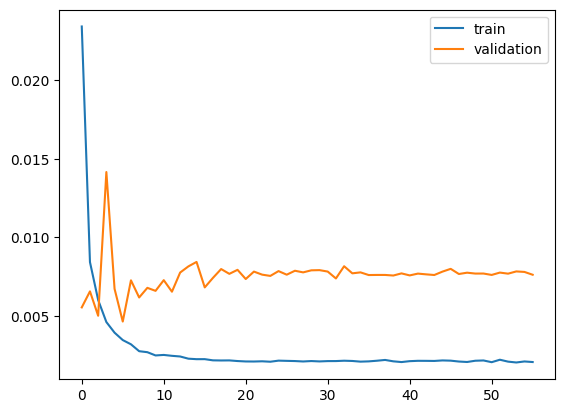

In [16]:
# Post-training analysis
# Check for underfitting
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
# plt.plot(history.history['val_abs_pred'], label='pred vs true')
plt.legend()
plt.show()

In [13]:
import numpy as np
from numpy import genfromtxt
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
import Faraz.CNN_FEM.Griddata_import as griddata


In [19]:
data = genfromtxt('/home/mike-pi/Documents/coding/Fedya_ML/Data/unzipped_faraz/surfaceCSVs/0-sigmaSurface.csv', delimiter=' ')
sigma=np.zeros(shape=(1,1071))
sigma.fill(1000/50000)
coordinates=data[:,[0,1]].T

start_time = time.time()

y_pred = model.predict([coordinates.T,sigma.T])

print("--- %s seconds ---" % (time.time() - start_time))

y_predScaled=y_pred*50000

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- 0.08217239379882812 seconds ---


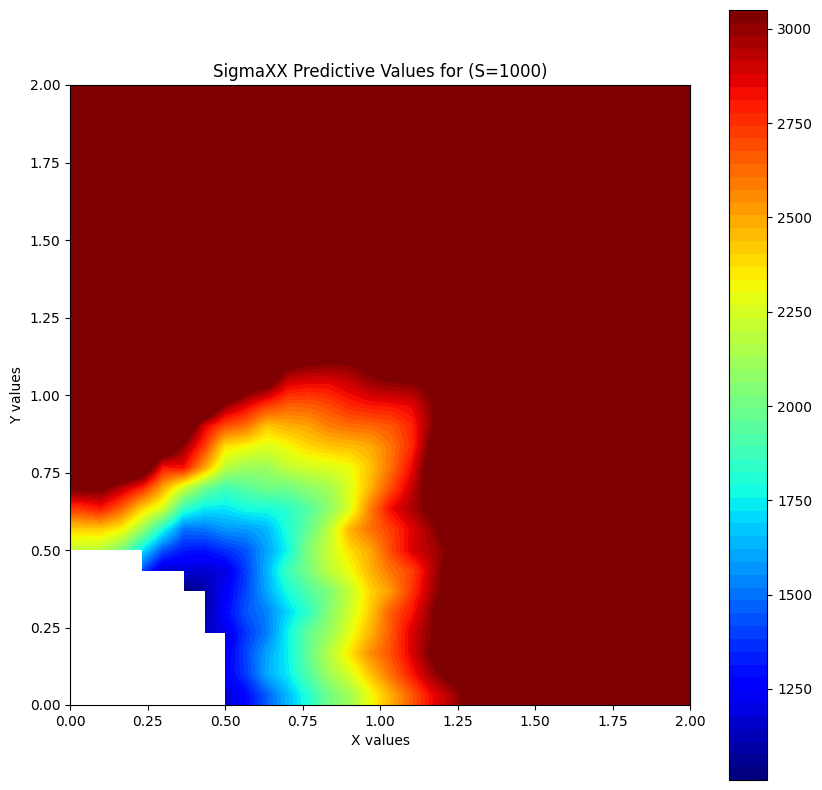

In [20]:
xx=coordinates[0,]
yy=coordinates[1,]
zz=y_predScaled
x=xx.ravel()
y=yy.ravel()
z=zz.ravel()
xi = np.linspace(0, 2, 5000)
yi = np.linspace(0, 2, 5000)

binsize = 0.07
grid, bins, binloc = griddata.griddata(x, y, z, binsize=binsize)
zmin    = grid[np.where(np.isnan(grid) == False)].min()
zmax    = grid[np.where(np.isnan(grid) == False)].max()

palette = plt.matplotlib.colors.LinearSegmentedColormap('jet1',plt.cm.datad['jet'],60)
palette.set_under(alpha=0.0)
extent = (x.min(), x.max(), y.min(), y.max())
# plt.rcParams["font.family"] = "arial"
# plt.rcParams["font.size"] = "16"
plt.figure(figsize=(10,10))
plt.imshow(grid, extent=extent, cmap=palette, origin='lower', vmin=zmin, vmax=3050, aspect='1', interpolation='bilinear')
cbar=plt.colorbar()

plt.title('SigmaXX Predictive Values for (S=1000)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.savefig('testplot.png')
#Image.open('testplot.png').save('testplot.jpg','JPEG')